<a href="https://www.kaggle.com/code/mahfuzurmahimrahman/apparel-inceptionnet?scriptVersionId=172983563" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import random_split

In [2]:
transform = transforms.Compose([
    transforms.Resize(299),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
dataset = datasets.ImageFolder(root='/kaggle/input/apparel-dataset', transform=transform)
print(f'Found {len(dataset)} images belonging to {len(dataset.classes)} classes.')

# Define the size of your validation set
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'Using {len(train_dataset)} images for training.')
print(f'Using {len(val_dataset)} images for validation.')

Found 16170 images belonging to 37 classes.
Using 12936 images for training.
Using 3234 images for validation.


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model = models.inception_v3(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 162MB/s] 


In [5]:
num_class = len(dataset.classes)

num_ftrs = model.AuxLogits.fc.in_features

model.AuxLogits.fc = nn.Linear(num_ftrs, num_class)  

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_class)
print(f"{num_ftrs}, {num_class}")

2048, 37


In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = model.to(device)

Using device: cuda


In [8]:
num_epochs = 5
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Model Train
    model.train()
    train_loss = 0
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    
    for inputs, labels in train_progress_bar:
        inputs = inputs.to(device)
        #print(inputs.shape)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update progress bar [resnet50(progress = True)]
        train_progress_bar.set_postfix({'loss': loss.item()})
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Model validation
    model.eval()
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    correct = 0
    total = 0
    for inputs, labels in val_progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

Epoch 1/5 [Training]:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 2/5 [Training]:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 3/5 [Training]:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 4/5 [Training]:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 5/5 [Training]:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/102 [00:00<?, ?it/s]

In [9]:
model = model
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

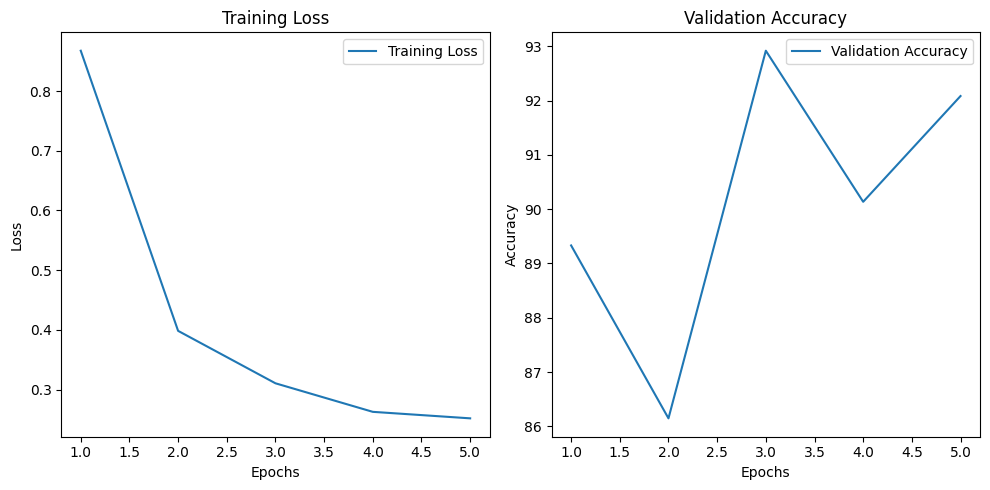

In [10]:
import matplotlib.pyplot as plt

#training loss visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

#validation visualize
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()